# Autoencoder Content-Based Recommender - NO MOOD

Same as the Autoencoder Content-Based but without the Mood column.

In [2]:
from comet_ml import Experiment
experiment = Experiment(api_key="ummagUWZ5eIZzmhPtFkA8oopu")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
[codecarbon INFO @ 11:19:05] [setup] RAM Tracking...
[codecarbon INFO @ 11:19:05] [setup] GPU Tracking...
[codecarbon INFO @ 11:19:05] No GPU found.
[codecarbon INFO @ 11:19:05] [setup] CPU Tracking...
[codecarbon WARNING @ 11:19:05] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 11:19:06] We saw that you have a Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 11:19:06] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 11:19:06] >>> Tracker's metadata:
[codecarbon INFO @ 11:19:06]   Platform system: Linux-5.4.0-147-generic-x86_64-with-glibc2.29
[codecarbon INFO @ 11:19:06]   Python version: 3.8.10
[codecarbon INFO @ 11:19:06]   Available RAM : 31.360 GB
[codecarbon INFO @ 11:1

In [3]:
from tqdm import tqdm
import time

import csv
import numpy as np
import pandas as pd
import scipy.sparse as sp

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity 

import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from keras.layers import (GlobalAveragePooling2D, Flatten, Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, AlphaDropout, MaxPooling2D, UpSampling2D, Rescaling, Resizing, LeakyReLU)
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from keras import Sequential, Model

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-lrlfharb because the default path (/home/asadcor/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2023-05-04 11:19:16.543328: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-04 11:19:16.543385: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Part 1: Autoencoder

In [4]:
playlists_dataset_with_mood = pd.read_csv('working/playlists_dataset_with_mood.csv')

### Data cleaning

In [5]:
df_unique_songs = playlists_dataset_with_mood.drop_duplicates(['track_uri'])

df_tracks = df_unique_songs['track_uri']
df_track_names = df_unique_songs['track_name']

df_songs_clean = df_unique_songs.drop(columns=[
    'pid', 'pos', 'name', 'description', 'modified_at', 'num_tracks','num_albums','num_followers',
    'num_edits', 'artist_name', 'track_name','album_name', 'track_uri','album_release_date', 'mood'])


mean_popularity = df_songs_clean['track_popularity'].mean()
df_songs_clean['track_popularity'] = df_songs_clean['track_popularity'].fillna(mean_popularity)

df_songs_clean['track_explicit'] = df_songs_clean['track_explicit'].fillna(False)

df_songs_clean['track_explicit'] = df_songs_clean['track_explicit'].astype(int)

In [6]:
# index reset
df_songs_clean = df_songs_clean.reset_index(drop=True)

In [7]:
# mood_map = {'Energetic': np.array([0, 1]),'Calm': np.array([0, -1]),'Sad': np.array([-1, 0]),'Happy': np.array([1, 0]),'Anxious': np.array([-1, 1]),'Depression': np.array([-1, -1]),'Exuberance': np.array([1, 1]),'Contentment': np.array([1, -1])}
# df_songs_clean['mood'] = df_songs_clean['mood'].map(mood_map)

In [8]:
df_songs_clean.head(4)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity,track_explicit
0,0.674,0.413,2,-7.816,1,0.0274,0.836,0.000019,0.0980,0.503,124.893,237907,3,68.0,0
1,0.630,0.530,0,-7.259,1,0.0434,0.400,0.000000,0.1770,0.417,108.038,225053,3,79.0,0
2,0.456,0.636,1,-6.552,1,0.0432,0.462,0.000189,0.2520,0.492,183.866,205760,3,33.0,0
3,0.586,0.128,7,-9.297,1,0.0496,0.963,0.000000,0.0858,0.371,123.498,276067,4,69.0,0


[codecarbon INFO @ 11:19:25] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:19:25] Energy consumed for all CPUs : 0.000177 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:19:25] 0.000226 kWh of electricity used since the begining.


### Standardizing the data

In [9]:
scaler = MinMaxScaler()
scaler.fit(df_songs_clean)
songs_scaled = scaler.transform(df_songs_clean)

In [10]:
songs_scaled.shape

(268230, 15)

[codecarbon INFO @ 11:19:40] Energy consumed for RAM : 0.000098 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:19:40] Energy consumed for all CPUs : 0.000354 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:19:40] 0.000452 kWh of electricity used since the begining.


In [11]:
df_songs_scaled = pd.DataFrame(songs_scaled)
df_songs_scaled.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.680808,0.413,0.181818,0.807327,1.0,0.028277,0.839357,0.000019,0.0980,0.503,0.506762,0.043487,0.6,0.739130,0.0
1,0.636364,0.530,0.000000,0.815944,1.0,0.044788,0.401606,0.000000,0.1770,0.417,0.438372,0.041107,0.6,0.858696,0.0
2,0.460606,0.636,0.090909,0.826882,1.0,0.044582,0.463855,0.000189,0.2520,0.492,0.746049,0.037535,0.6,0.358696,0.0
3,0.591919,0.128,0.636364,0.784415,1.0,0.051187,0.966867,0.000000,0.0858,0.371,0.501102,0.050553,0.8,0.750000,0.0


[codecarbon INFO @ 11:19:55] Energy consumed for RAM : 0.000147 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:19:55] Energy consumed for all CPUs : 0.000531 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:19:55] 0.000678 kWh of electricity used since the begining.


In [12]:
train, val_test = train_test_split(songs_scaled, test_size=0.2, shuffle=True, random_state=12)
val, test = train_test_split(val_test, test_size=0.5, shuffle=True, random_state=12)

[codecarbon INFO @ 11:20:10] Energy consumed for RAM : 0.000196 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:20:10] Energy consumed for all CPUs : 0.000708 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:20:10] 0.000904 kWh of electricity used since the begining.
[codecarbon INFO @ 11:20:25] Energy consumed for RAM : 0.000245 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:20:25] Energy consumed for all CPUs : 0.000885 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:20:25] 0.001130 kWh of electricity used since the begining.
[codecarbon INFO @ 11:20:40] Energy consumed for RAM : 0.000294 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:20:40] Energy consumed for all CPUs : 0.001062 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:20:40] 0.001356 kWh of electricity used since the begining.
[codecarbon INFO @ 11:20:55] Energy consumed for RAM : 0.000343 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:20:55] Energy consumed for all

## Autoencoder design and training


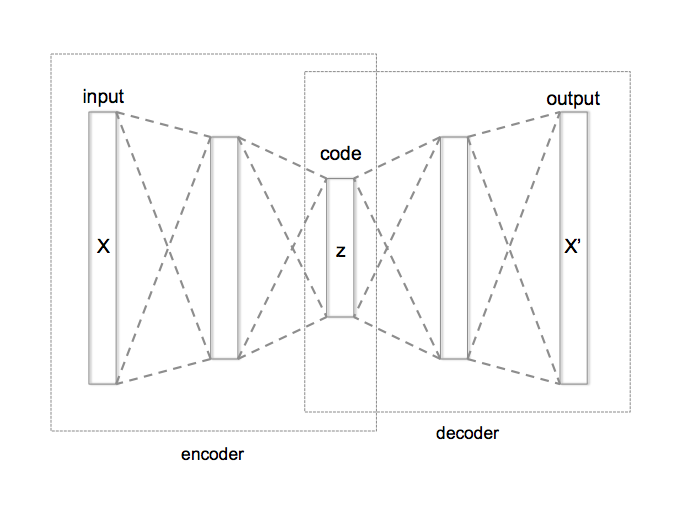
A well-trained autoencoder is capable to provide a good latent representation. This representation is quite different from the original data but it has all the information contained in the input layer.

https://datascience.stackexchange.com/questions/33338/autoencoder-for-features-selection

In [17]:
input_song = keras.layers.Input(shape=(15,))

# Encoder
x = Dense(128, activation='relu')(input_song)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)

x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)

x = Dense(16, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)

encoded = Dense(8, activation='relu')(x)

# Decoder
x = Dense(16, activation='relu')(encoded)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)

x = Dense(32, activation='relu')(encoded)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)

decoded = Dense(15, activation='sigmoid')(x)

autoencoder_ = Model(inputs=input_song, outputs=decoded)

In [18]:
# Compile model
autoencoder_.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['accuracy'])


# EarlyStopping,ReduceLROnPlateau, and ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min')
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

model_checkpoint_autoencoder = ModelCheckpoint('models/autoencoder_no_mood/best_weights_autoencoder.h5',
                                       monitor='val_loss',
                                       save_best_only=True,
                                       mode='min')

In [19]:
# Train model
start_time = time.time()

trained_model_autoencoder_ = autoencoder_.fit(
    train, train,
    epochs=100,
    validation_data=(val, val),
    callbacks=[early_stop, model_checkpoint_autoencoder],
    verbose=1)

end_time = time.time()
print('Training time: ' + str(round((end_time-start_time)/60,2)) + " minutes")

Epoch 1/100


COMET INFO: ignoring tensorflow summary log of metrics because of keras; set `comet_ml.loggers.tensorboard_logger.LOG_METRICS = True` to override


 483/6706 [=>............................] - ETA: 22s - loss: 0.0683 - accuracy: 0.3493

[codecarbon INFO @ 11:22:40] Energy consumed for RAM : 0.000686 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:22:40] Energy consumed for all CPUs : 0.002479 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:22:40] 0.003165 kWh of electricity used since the begining.


4524/6706 [===================>..........] - ETA: 8s - loss: 0.0321 - accuracy: 0.6587

[codecarbon INFO @ 11:22:55] Energy consumed for RAM : 0.000735 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:22:55] Energy consumed for all CPUs : 0.002656 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:22:55] 0.003391 kWh of electricity used since the begining.


6706/6706 [==============================] - 28s 4ms/step - loss: 0.0286 - accuracy: 0.6853 - val_loss: 0.0144 - val_accuracy: 0.7891
Epoch 2/100
1515/6706 [=====>........................] - ETA: 18s - loss: 0.0196 - accuracy: 0.7539

[codecarbon INFO @ 11:23:10] Energy consumed for RAM : 0.000784 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:23:10] Energy consumed for all CPUs : 0.002833 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:23:10] 0.003617 kWh of electricity used since the begining.


5607/6706 [========================>.....] - ETA: 4s - loss: 0.0186 - accuracy: 0.7627

[codecarbon INFO @ 11:23:25] Energy consumed for RAM : 0.000833 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:23:25] Energy consumed for all CPUs : 0.003010 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:23:25] 0.003843 kWh of electricity used since the begining.


6706/6706 [==============================] - 25s 4ms/step - loss: 0.0185 - accuracy: 0.7645 - val_loss: 0.0119 - val_accuracy: 0.8260
Epoch 3/100
2730/6706 [===========>..................] - ETA: 14s - loss: 0.0168 - accuracy: 0.7788

[codecarbon INFO @ 11:23:40] Energy consumed for RAM : 0.000882 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:23:40] Energy consumed for all CPUs : 0.003187 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:23:40] 0.004069 kWh of electricity used since the begining.


6700/6706 [============================>.] - ETA: 0s - loss: 0.0162 - accuracy: 0.7799

[codecarbon INFO @ 11:23:55] Energy consumed for RAM : 0.000931 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:23:55] Energy consumed for all CPUs : 0.003364 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:23:55] 0.004295 kWh of electricity used since the begining.


6706/6706 [==============================] - 25s 4ms/step - loss: 0.0162 - accuracy: 0.7798 - val_loss: 0.0095 - val_accuracy: 0.8313
Epoch 4/100
3953/6706 [================>.............] - ETA: 10s - loss: 0.0148 - accuracy: 0.7851

[codecarbon INFO @ 11:24:10] Energy consumed for RAM : 0.000980 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:24:10] Energy consumed for all CPUs : 0.003541 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:24:10] 0.004521 kWh of electricity used since the begining.


6706/6706 [==============================] - 26s 4ms/step - loss: 0.0144 - accuracy: 0.7873 - val_loss: 0.0085 - val_accuracy: 0.8315
Epoch 5/100
1033/6706 [===>..........................] - ETA: 20s - loss: 0.0134 - accuracy: 0.7934

[codecarbon INFO @ 11:24:25] Energy consumed for RAM : 0.001029 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:24:25] Energy consumed for all CPUs : 0.003718 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:24:25] 0.004747 kWh of electricity used since the begining.


5177/6706 [======================>.......] - ETA: 5s - loss: 0.0130 - accuracy: 0.7960

[codecarbon INFO @ 11:24:40] Energy consumed for RAM : 0.001078 kWh. RAM Power : 11.759872913360596 W


5191/6706 [======================>.......] - ETA: 5s - loss: 0.0129 - accuracy: 0.7960

[codecarbon INFO @ 11:24:40] Energy consumed for all CPUs : 0.003895 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:24:40] 0.004973 kWh of electricity used since the begining.


6706/6706 [==============================] - 26s 4ms/step - loss: 0.0128 - accuracy: 0.7973 - val_loss: 0.0073 - val_accuracy: 0.8364
Epoch 6/100
2276/6706 [=========>....................] - ETA: 15s - loss: 0.0120 - accuracy: 0.8041

[codecarbon INFO @ 11:24:55] Energy consumed for RAM : 0.001127 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:24:55] Energy consumed for all CPUs : 0.004072 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:24:55] 0.005199 kWh of electricity used since the begining.


6427/6706 [===========================>..] - ETA: 1s - loss: 0.0119 - accuracy: 0.8026

[codecarbon INFO @ 11:25:10] Energy consumed for RAM : 0.001176 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:25:10] Energy consumed for all CPUs : 0.004249 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:25:10] 0.005425 kWh of electricity used since the begining.


6706/6706 [==============================] - 25s 4ms/step - loss: 0.0118 - accuracy: 0.8022 - val_loss: 0.0069 - val_accuracy: 0.8440
Epoch 7/100
3518/6706 [==============>...............] - ETA: 11s - loss: 0.0114 - accuracy: 0.8029

[codecarbon INFO @ 11:25:25] Energy consumed for RAM : 0.001225 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:25:25] Energy consumed for all CPUs : 0.004427 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:25:25] 0.005651 kWh of electricity used since the begining.


6706/6706 [==============================] - 26s 4ms/step - loss: 0.0114 - accuracy: 0.8022 - val_loss: 0.0069 - val_accuracy: 0.8559
Epoch 8/100
 533/6706 [=>............................] - ETA: 22s - loss: 0.0113 - accuracy: 0.7947

[codecarbon INFO @ 11:25:40] Energy consumed for RAM : 0.001274 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:25:40] Energy consumed for all CPUs : 0.004604 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:25:40] 0.005877 kWh of electricity used since the begining.


4694/6706 [===================>..........] - ETA: 7s - loss: 0.0112 - accuracy: 0.8009

[codecarbon INFO @ 11:25:55] Energy consumed for RAM : 0.001323 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:25:55] Energy consumed for all CPUs : 0.004781 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:25:55] 0.006103 kWh of electricity used since the begining.


6706/6706 [==============================] - 25s 4ms/step - loss: 0.0111 - accuracy: 0.8006 - val_loss: 0.0065 - val_accuracy: 0.8426
Epoch 9/100
1800/6706 [=======>......................] - ETA: 17s - loss: 0.0111 - accuracy: 0.8004

[codecarbon INFO @ 11:26:10] Energy consumed for RAM : 0.001372 kWh. RAM Power : 11.759872913360596 W


1814/6706 [=======>......................] - ETA: 17s - loss: 0.0111 - accuracy: 0.8002

[codecarbon INFO @ 11:26:10] Energy consumed for all CPUs : 0.004958 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:26:10] 0.006329 kWh of electricity used since the begining.


5912/6706 [=========================>....] - ETA: 2s - loss: 0.0110 - accuracy: 0.8008

[codecarbon INFO @ 11:26:25] Energy consumed for RAM : 0.001421 kWh. RAM Power : 11.759872913360596 W


5926/6706 [=========================>....] - ETA: 2s - loss: 0.0110 - accuracy: 0.8007

[codecarbon INFO @ 11:26:25] Energy consumed for all CPUs : 0.005135 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:26:25] 0.006555 kWh of electricity used since the begining.


6706/6706 [==============================] - 26s 4ms/step - loss: 0.0110 - accuracy: 0.8006 - val_loss: 0.0063 - val_accuracy: 0.8603
Epoch 10/100
2851/6706 [===========>..................] - ETA: 14s - loss: 0.0109 - accuracy: 0.8012

[codecarbon INFO @ 11:26:40] Energy consumed for RAM : 0.001470 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:26:40] Energy consumed for all CPUs : 0.005312 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:26:40] 0.006781 kWh of electricity used since the begining.


6692/6706 [============================>.] - ETA: 0s - loss: 0.0108 - accuracy: 0.8030

[codecarbon INFO @ 11:26:55] Energy consumed for RAM : 0.001519 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:26:55] Energy consumed for all CPUs : 0.005489 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:26:55] 0.007007 kWh of electricity used since the begining.


6706/6706 [==============================] - 26s 4ms/step - loss: 0.0108 - accuracy: 0.8031 - val_loss: 0.0062 - val_accuracy: 0.8537
Epoch 11/100
4083/6706 [=================>............] - ETA: 9s - loss: 0.0107 - accuracy: 0.8048

[codecarbon INFO @ 11:27:10] Energy consumed for RAM : 0.001567 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:27:10] Energy consumed for all CPUs : 0.005666 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:27:10] 0.007233 kWh of electricity used since the begining.


6706/6706 [==============================] - 25s 4ms/step - loss: 0.0107 - accuracy: 0.8057 - val_loss: 0.0063 - val_accuracy: 0.8584
Epoch 12/100
1209/6706 [====>.........................] - ETA: 19s - loss: 0.0107 - accuracy: 0.8066

[codecarbon INFO @ 11:27:25] Energy consumed for RAM : 0.001616 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:27:25] Energy consumed for all CPUs : 0.005843 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:27:25] 0.007459 kWh of electricity used since the begining.


5280/6706 [======================>.......] - ETA: 5s - loss: 0.0106 - accuracy: 0.8051

[codecarbon INFO @ 11:27:40] Energy consumed for RAM : 0.001665 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:27:40] Energy consumed for all CPUs : 0.006020 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:27:40] 0.007685 kWh of electricity used since the begining.


6706/6706 [==============================] - 26s 4ms/step - loss: 0.0106 - accuracy: 0.8053 - val_loss: 0.0062 - val_accuracy: 0.8599
Epoch 13/100
2311/6706 [=========>....................] - ETA: 16s - loss: 0.0105 - accuracy: 0.8020

[codecarbon INFO @ 11:27:55] Energy consumed for RAM : 0.001714 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:27:55] Energy consumed for all CPUs : 0.006197 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:27:55] 0.007912 kWh of electricity used since the begining.


6493/6706 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.8058

[codecarbon INFO @ 11:28:10] Energy consumed for RAM : 0.001763 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:28:10] Energy consumed for all CPUs : 0.006374 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:28:10] 0.008138 kWh of electricity used since the begining.


6706/6706 [==============================] - 25s 4ms/step - loss: 0.0105 - accuracy: 0.8062 - val_loss: 0.0061 - val_accuracy: 0.8608
Epoch 14/100
3615/6706 [===============>..............] - ETA: 11s - loss: 0.0104 - accuracy: 0.8079

[codecarbon INFO @ 11:28:25] Energy consumed for RAM : 0.001812 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:28:25] Energy consumed for all CPUs : 0.006551 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:28:25] 0.008364 kWh of electricity used since the begining.


6706/6706 [==============================] - 25s 4ms/step - loss: 0.0104 - accuracy: 0.8082 - val_loss: 0.0060 - val_accuracy: 0.8465
Epoch 15/100
 729/6706 [==>...........................] - ETA: 21s - loss: 0.0103 - accuracy: 0.8073

[codecarbon INFO @ 11:28:40] Energy consumed for RAM : 0.001861 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:28:40] Energy consumed for all CPUs : 0.006728 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:28:40] 0.008590 kWh of electricity used since the begining.


4866/6706 [====================>.........] - ETA: 6s - loss: 0.0103 - accuracy: 0.8080

[codecarbon INFO @ 11:28:55] Energy consumed for RAM : 0.001910 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:28:55] Energy consumed for all CPUs : 0.006905 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:28:55] 0.008816 kWh of electricity used since the begining.


6706/6706 [==============================] - 25s 4ms/step - loss: 0.0103 - accuracy: 0.8082 - val_loss: 0.0059 - val_accuracy: 0.8580
Epoch 16/100
1948/6706 [=======>......................] - ETA: 17s - loss: 0.0103 - accuracy: 0.8054

[codecarbon INFO @ 11:29:10] Energy consumed for RAM : 0.001959 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:29:10] Energy consumed for all CPUs : 0.007082 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:29:10] 0.009042 kWh of electricity used since the begining.


6089/6706 [==========================>...] - ETA: 2s - loss: 0.0102 - accuracy: 0.8063

[codecarbon INFO @ 11:29:25] Energy consumed for RAM : 0.002008 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:29:25] Energy consumed for all CPUs : 0.007259 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:29:25] 0.009268 kWh of electricity used since the begining.


6706/6706 [==============================] - 25s 4ms/step - loss: 0.0102 - accuracy: 0.8069 - val_loss: 0.0057 - val_accuracy: 0.8575
Epoch 17/100
3183/6706 [=============>................] - ETA: 12s - loss: 0.0101 - accuracy: 0.8035

[codecarbon INFO @ 11:29:40] Energy consumed for RAM : 0.002057 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:29:40] Energy consumed for all CPUs : 0.007437 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:29:40] 0.009494 kWh of electricity used since the begining.


6706/6706 [==============================] - 25s 4ms/step - loss: 0.0101 - accuracy: 0.8058 - val_loss: 0.0063 - val_accuracy: 0.8372
Epoch 18/100
 348/6706 [>.............................] - ETA: 22s - loss: 0.0103 - accuracy: 0.8051

[codecarbon INFO @ 11:29:55] Energy consumed for RAM : 0.002106 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:29:55] Energy consumed for all CPUs : 0.007614 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:29:55] 0.009720 kWh of electricity used since the begining.


4543/6706 [===================>..........] - ETA: 7s - loss: 0.0102 - accuracy: 0.8069

[codecarbon INFO @ 11:30:10] Energy consumed for RAM : 0.002155 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:30:10] Energy consumed for all CPUs : 0.007791 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:30:10] 0.009946 kWh of electricity used since the begining.


6706/6706 [==============================] - 25s 4ms/step - loss: 0.0101 - accuracy: 0.8080 - val_loss: 0.0059 - val_accuracy: 0.8631
Epoch 19/100
1585/6706 [======>.......................] - ETA: 19s - loss: 0.0101 - accuracy: 0.8109

[codecarbon INFO @ 11:30:25] Energy consumed for RAM : 0.002204 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:30:25] Energy consumed for all CPUs : 0.007968 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:30:25] 0.010172 kWh of electricity used since the begining.


5775/6706 [========================>.....] - ETA: 3s - loss: 0.0101 - accuracy: 0.8085

[codecarbon INFO @ 11:30:40] Energy consumed for RAM : 0.002253 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:30:40] Energy consumed for all CPUs : 0.008145 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:30:40] 0.010398 kWh of electricity used since the begining.


6706/6706 [==============================] - 26s 4ms/step - loss: 0.0101 - accuracy: 0.8081 - val_loss: 0.0061 - val_accuracy: 0.8490
Epoch 20/100
2837/6706 [===========>..................] - ETA: 14s - loss: 0.0100 - accuracy: 0.8085

[codecarbon INFO @ 11:30:55] Energy consumed for RAM : 0.002302 kWh. RAM Power : 11.759872913360596 W


2852/6706 [===========>..................] - ETA: 14s - loss: 0.0100 - accuracy: 0.8086

[codecarbon INFO @ 11:30:55] Energy consumed for all CPUs : 0.008322 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:30:55] 0.010624 kWh of electricity used since the begining.


6706/6706 [==============================] - 25s 4ms/step - loss: 0.0101 - accuracy: 0.8076 - val_loss: 0.0059 - val_accuracy: 0.8512
Epoch 21/100
  26/6706 [..............................] - ETA: 27s - loss: 0.0099 - accuracy: 0.7873

[codecarbon INFO @ 11:31:10] Energy consumed for RAM : 0.002351 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:31:10] Energy consumed for all CPUs : 0.008499 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:31:10] 0.010850 kWh of electricity used since the begining.


4087/6706 [=================>............] - ETA: 9s - loss: 0.0100 - accuracy: 0.8118

[codecarbon INFO @ 11:31:25] Energy consumed for RAM : 0.002400 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:31:25] Energy consumed for all CPUs : 0.008676 kWh. All CPUs Power : 42.5 W


4102/6706 [=================>............] - ETA: 9s - loss: 0.0100 - accuracy: 0.8118

[codecarbon INFO @ 11:31:25] 0.011076 kWh of electricity used since the begining.


6706/6706 [==============================] - 25s 4ms/step - loss: 0.0100 - accuracy: 0.8118 - val_loss: 0.0062 - val_accuracy: 0.8612
Epoch 22/100
1246/6706 [====>.........................] - ETA: 20s - loss: 0.0100 - accuracy: 0.8144

[codecarbon INFO @ 11:31:40] Energy consumed for RAM : 0.002449 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:31:40] Energy consumed for all CPUs : 0.008853 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:31:40] 0.011302 kWh of electricity used since the begining.


5356/6706 [======================>.......] - ETA: 4s - loss: 0.0100 - accuracy: 0.8109

[codecarbon INFO @ 11:31:55] Energy consumed for RAM : 0.002498 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:31:55] Energy consumed for all CPUs : 0.009030 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:31:55] 0.011528 kWh of electricity used since the begining.


6706/6706 [==============================] - 26s 4ms/step - loss: 0.0100 - accuracy: 0.8108 - val_loss: 0.0059 - val_accuracy: 0.8606
Epoch 23/100
2437/6706 [=========>....................] - ETA: 15s - loss: 0.0099 - accuracy: 0.8107

[codecarbon INFO @ 11:32:10] Energy consumed for RAM : 0.002547 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:32:10] Energy consumed for all CPUs : 0.009207 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:32:10] 0.011754 kWh of electricity used since the begining.


6575/6706 [============================>.] - ETA: 0s - loss: 0.0099 - accuracy: 0.8076

[codecarbon INFO @ 11:32:25] Energy consumed for RAM : 0.002596 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:32:25] Energy consumed for all CPUs : 0.009384 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:32:25] 0.011980 kWh of electricity used since the begining.


6706/6706 [==============================] - 25s 4ms/step - loss: 0.0099 - accuracy: 0.8077 - val_loss: 0.0059 - val_accuracy: 0.8391
Epoch 24/100
3737/6706 [===============>..............] - ETA: 10s - loss: 0.0099 - accuracy: 0.8075

[codecarbon INFO @ 11:32:40] Energy consumed for RAM : 0.002645 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:32:40] Energy consumed for all CPUs : 0.009561 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:32:40] 0.012206 kWh of electricity used since the begining.


6706/6706 [==============================] - 25s 4ms/step - loss: 0.0099 - accuracy: 0.8087 - val_loss: 0.0058 - val_accuracy: 0.8572
Epoch 25/100
 894/6706 [==>...........................] - ETA: 21s - loss: 0.0100 - accuracy: 0.8124

[codecarbon INFO @ 11:32:55] Energy consumed for RAM : 0.002694 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:32:55] Energy consumed for all CPUs : 0.009738 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:32:55] 0.012432 kWh of electricity used since the begining.


4988/6706 [=====================>........] - ETA: 6s - loss: 0.0099 - accuracy: 0.8100

[codecarbon INFO @ 11:33:10] Energy consumed for RAM : 0.002743 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:33:10] Energy consumed for all CPUs : 0.009915 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:33:10] 0.012658 kWh of electricity used since the begining.


6706/6706 [==============================] - 26s 4ms/step - loss: 0.0099 - accuracy: 0.8099 - val_loss: 0.0058 - val_accuracy: 0.8472
Epoch 26/100
2155/6706 [========>.....................] - ETA: 16s - loss: 0.0099 - accuracy: 0.8091

[codecarbon INFO @ 11:33:25] Energy consumed for RAM : 0.002792 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:33:25] Energy consumed for all CPUs : 0.010092 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:33:25] 0.012885 kWh of electricity used since the begining.


6208/6706 [==========================>...] - ETA: 1s - loss: 0.0099 - accuracy: 0.8101

[codecarbon INFO @ 11:33:40] Energy consumed for RAM : 0.002841 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:33:40] Energy consumed for all CPUs : 0.010269 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:33:40] 0.013111 kWh of electricity used since the begining.


6706/6706 [==============================] - 26s 4ms/step - loss: 0.0099 - accuracy: 0.8106 - val_loss: 0.0058 - val_accuracy: 0.8515
Training time: 11.11 minutes


6706/6706 [==============================] - 26s 4ms/step - loss: 0.0099 - accuracy: 0.8106 - val_loss: 0.0058 - val_accuracy: 0.8515
Training time: 11.11 minutes

vs

6706/6706 [==============================] - 24s 4ms/step - loss: 0.0054 - accuracy: 0.7746 - val_loss: 0.0025 - val_accuracy: 0.8688
Training time: 27.73 minutes

In [20]:
def plot_prediction(mfit, hide_plot=None):
     """
    Plots the training loss and accuracy curves.

    Parameters:
        mfit (keras.callbacks.History): The History object obtained from model training.
        hide_plot (bool, optional): Specifies whether to hide the plot or display it. Defaults to None.

    """
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
    fig.suptitle('Training Loss and Accuracy')
    
    if hide_plot != 'loss':
        ax1.plot(mfit.history["loss"], label="train_loss")
        ax1.plot(mfit.history["val_loss"], label="val_loss")
        ax1.set_title("Loss")
        ax1.set_xlabel("epoch")
        ax1.set_ylabel("loss")
        ax1.legend(loc="lower left")
    else:
        ax1.set_visible(False)
        ax1.axis('off')
        fig.suptitle('Training Accuracy')
        fig.set_size_inches(18,6)
    
    if hide_plot != 'accuracy':
        ax2.plot(mfit.history["accuracy"], label="train_accuracy")
        ax2.plot(mfit.history["val_accuracy"], label="val_accuracy")
        ax2.set_title("Accuracy")
        ax2.set_xlabel("epoch")
        ax2.set_ylabel("accuracy")
        ax2.legend(loc="lower left")
    else:
        ax2.set_visible(False)
        ax2.axis('off')
        fig.suptitle('Training Loss')
        fig.set_size_inches(18,6)
    
    plt.show()

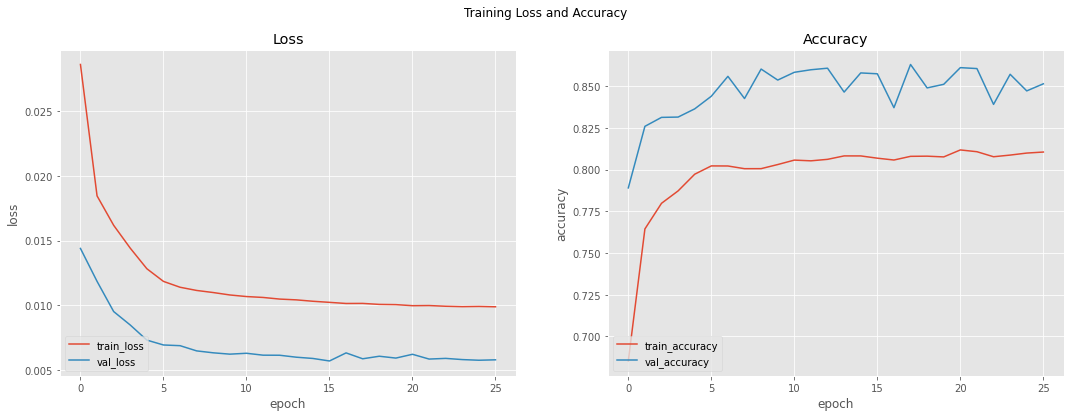

In [21]:
plot_prediction(trained_model_autoencoder_)

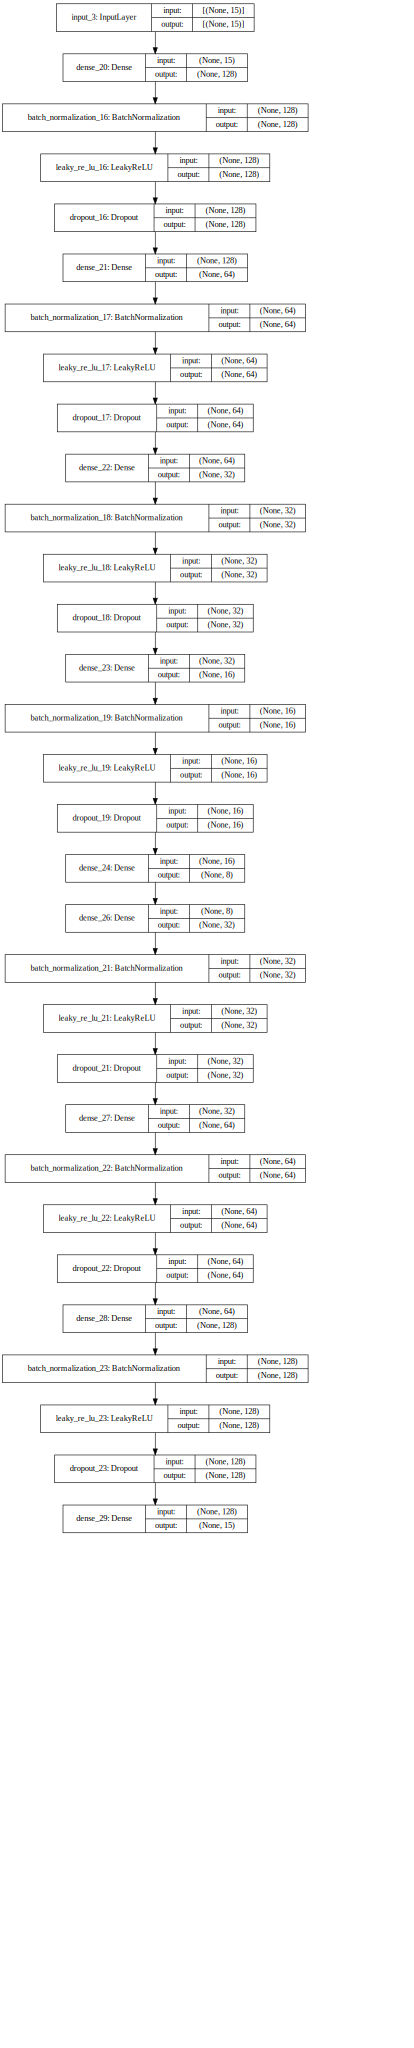

In [22]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

SVG(model_to_dot(autoencoder_, show_shapes=True, show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

In [23]:
autoencoder_._name = 'autoencoder_model'
autoencoder_.summary()

Model: "autoencoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               2048      
_________________________________________________________________
batch_normalization_16 (Batc (None, 128)               512       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_17 (Batc (None, 64)          

### Evaluation

In [24]:
loss, accuracy = autoencoder_.evaluate(test, test, verbose=0)

print("Final loss in test data:", loss)
print("Final accuracy in test data:", accuracy)

Final loss in test data: 0.005746229086071253
Final accuracy in test data: 0.8531857132911682


[codecarbon INFO @ 11:33:55] Energy consumed for RAM : 0.002890 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:33:55] Energy consumed for all CPUs : 0.010447 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:33:55] 0.013337 kWh of electricity used since the begining.
[codecarbon INFO @ 11:34:10] Energy consumed for RAM : 0.002939 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:34:10] Energy consumed for all CPUs : 0.010624 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:34:10] 0.013563 kWh of electricity used since the begining.
[codecarbon INFO @ 11:34:25] Energy consumed for RAM : 0.002988 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:34:25] Energy consumed for all CPUs : 0.010801 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:34:25] 0.013789 kWh of electricity used since the begining.
[codecarbon INFO @ 11:34:40] Energy consumed for RAM : 0.003037 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:34:40] Energy consumed for all

In [22]:
# Compression ratio

compression_ratio = (23) / np.prod(autoencoder_.get_layer('dense_7').output_shape[1:])

print(f"Ratio de compresión: {compression_ratio:.2f}")

Ratio de compresión: 1.00


[codecarbon INFO @ 19:41:41] Energy consumed for RAM : 0.005731 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:41:41] Energy consumed for all CPUs : 0.020716 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:41:41] 0.026447 kWh of electricity used since the begining.


#### Encoder

In [28]:
encoder = Model(autoencoder_.input, autoencoder_.layers[17].output)
encoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               2048      
_________________________________________________________________
batch_normalization_16 (Batc (None, 128)               512       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_17 (Batc (None, 64)                256 

[codecarbon INFO @ 11:41:25] Energy consumed for RAM : 0.004359 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:41:25] Energy consumed for all CPUs : 0.015758 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:41:25] 0.020118 kWh of electricity used since the begining.


## Part 2: Content-Based Recommender

### Preprocess data and encoding

In [29]:
pdwm_10k = playlists_dataset_with_mood.sample(n=50000, random_state=12)

mask = pdwm_10k['pid'].duplicated(keep=False)
pdwm_10k_filtered = pdwm_10k[mask]

pdwm_10k_filtered.shape

(45464, 30)

In [30]:
train_r, val_test_r = train_test_split(pdwm_10k_filtered, test_size=0.3, random_state=10, stratify = pdwm_10k_filtered['pid'])

In [31]:
train_r

,pid,pos,name,description,modified_at,num_tracks,num_albums,num_followers,num_edits,artist_name,...,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,album_release_date,track_popularity,track_explicit,mood
112879,64725,96,ACL 2014,NaN,1404345600,246,114,1,14,AFI,...,0.000160,0.1240,0.672,121.836,190493,4,2003,62.0,False,Sad
1078162,631247,105,Forever,NaN,1509321600,133,85,2,14,J. Cole,...,0.000000,0.6890,0.482,81.004,278573,4,2013-06-14,19.0,True,Sad
48661,11747,139,favorite,NaN,1504742400,142,120,1,36,Kendrick Lamar,...,0.000054,0.0958,0.421,150.011,177000,4,2017-04-14,85.0,True,Energetic
310532,146743,12,Workout,NaN,1508198400,80,62,1,17,Chevelle,...,0.000060,0.2040,0.289,95.023,223173,3,1999-09-09,0.0,False,Sad
651937,308780,64,Cumbia Mix,NaN,1501027200,96,71,1,4,Los Yaguaru,...,0.000000,0.1050,0.946,171.616,224667,4,2002-01-01,0.0,False,Sad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003982,574085,2,Stuff I like,NaN,1509235200,54,48,1,8,Shawn Mendes,...,0.000000,0.0486,0.764,149.882,206880,4,2015-04-13,0.0,False,Energetic
580951,282746,15,summer 17,NaN,1508112000,92,75,4,45,Lil Uzi Vert,...,0.000000,0.2080,0.398,139.952,175203,4,2016-08-10,67.0,True,Anxious
1218076,834411,18,oldies,NaN,1509408000,49,48,1,34,Calvin Harris,...,0.000001,0.2540,0.511,104.066,230813,4,2017-06-30,74.0,True,Sad
467137,198992,111,Christmas,NaN,1448323200,113,43,1,5,Dave Koz,...,0.000074,0.1100,0.737,96.973,251320,4,2014-01-01,2.0,False,Sad


[codecarbon INFO @ 11:41:40] Energy consumed for RAM : 0.004408 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:41:40] Energy consumed for all CPUs : 0.015935 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:41:40] 0.020344 kWh of electricity used since the begining.


In [32]:
train_r = train_r.reset_index(drop=True)

[codecarbon INFO @ 11:41:55] Energy consumed for RAM : 0.004457 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:41:55] Energy consumed for all CPUs : 0.016112 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:41:55] 0.020570 kWh of electricity used since the begining.
[codecarbon INFO @ 11:42:10] Energy consumed for RAM : 0.004506 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:42:10] Energy consumed for all CPUs : 0.016289 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:42:10] 0.020796 kWh of electricity used since the begining.


In [33]:
pdwm_10k_filteredT = train_r.copy()

mean_popularity = df_songs_clean['track_popularity'].mean()
pdwm_10k_filteredT.loc[:, 'track_popularity'] = pdwm_10k_filteredT['track_popularity'].fillna(mean_popularity)

pdwm_10k_filteredT.loc[:, 'track_explicit'] = pdwm_10k_filteredT['track_explicit'].fillna(False)

pdwm_10k_filteredT.loc[:, 'track_explicit'] = pdwm_10k_filteredT['track_explicit'].astype(int)

pdwm_10k_filteredT = pdwm_10k_filteredT.reset_index(drop=True)

[codecarbon INFO @ 11:42:25] Energy consumed for RAM : 0.004555 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:42:25] Energy consumed for all CPUs : 0.016466 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:42:25] 0.021022 kWh of electricity used since the begining.
[codecarbon INFO @ 11:42:40] Energy consumed for RAM : 0.004604 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:42:40] Energy consumed for all CPUs : 0.016644 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:42:40] 0.021248 kWh of electricity used since the begining.


In [34]:
df_unique_songs = pdwm_10k_filteredT.drop_duplicates(['track_uri'])

df_tracks = pdwm_10k_filteredT['track_uri']
df_track_names = pdwm_10k_filteredT['track_name']

train_clean_r = pdwm_10k_filteredT.drop(columns=[
    'pid', 'pos', 'name', 'description', 'modified_at', 'num_tracks','num_albums','num_followers',
    'num_edits', 'artist_name', 'track_name','album_name', 'track_uri','album_release_date', 'mood'])

In [35]:
t_scaler = MinMaxScaler()
t_scaler.fit(train_clean_r)
t_songs_scaled = t_scaler.transform(train_clean_r)

In [36]:
print(val_test_r.shape)
print(train_r.shape)
print(t_songs_scaled.shape)

(13640, 30)
(31824, 30)
(31824, 15)


[codecarbon INFO @ 11:42:55] Energy consumed for RAM : 0.004653 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:42:55] Energy consumed for all CPUs : 0.016821 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:42:55] 0.021474 kWh of electricity used since the begining.


After encoding the data with the encoder, we are left with a lower-dimensional representation of the original data, which still contains the most important features of the songs. 

In [37]:
# Encode
encoded_data = encoder.predict(t_songs_scaled)

In [38]:
encoded_data.shape

(31824, 8)

[codecarbon INFO @ 11:43:10] Energy consumed for RAM : 0.004702 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:43:10] Energy consumed for all CPUs : 0.016998 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:43:10] 0.021700 kWh of electricity used since the begining.


### Cosine Similarity Matrix

In [39]:
train_scaled_cos_matrix = cosine_similarity(encoded_data)

In [40]:
train_scaled_cos_matrix.shape

(31824, 31824)

In [41]:
def cos_similar_songs_playlist(cos_matrix, target_playlist_id, cand_list_size):
    """
    Generates a list of cosine-similar songs for a given target playlist.

    Parameters:
        cos_matrix (ndarray): The cosine similarity matrix.
        target_playlist_id (int): The ID of the target playlist.
        cand_list_size (int): The desired size of the candidate song list.

    Returns:
        list: A list of cosine-similar songs.

    """
    target_track_inx = np.where(train_r["pid"] == target_playlist_id)[0] # index of tracks in training playlist of target playlist
    candidate_cos_matrix = cos_matrix

    ## For each song in the playlist, find k similar songs
    cand_list = []
    # cand_list_size = k*15
    k = np.floor(cand_list_size/len(target_track_inx)) # round(cand_list_size/len(target_track_inx))
    k_rest = cand_list_size - k*len(target_track_inx)
    # e.g., for a candidate list size of 30, get 3 songs for each track first
    for inx, i in enumerate(target_track_inx):
        candidate_song_rec = candidate_cos_matrix[i, ] #ith row of matrix
        candidate_song_rec_inx = np.argsort(candidate_song_rec)
        unique_candidate_song_sorted = train_r['track_uri'][candidate_song_rec_inx][::-1].drop_duplicates()
        tracks_in_target_playlist = train_r.loc[train_r["pid"] == target_playlist_id, "track_uri"]
        song_to_recommend = np.array(unique_candidate_song_sorted.loc[~unique_candidate_song_sorted.isin(tracks_in_target_playlist)])

        if (k_rest != 0 & inx <= k_rest): # 30-24 = 6; for the first 6 tracks recommend k + 1 songs
            k_song_to_recommend = song_to_recommend[:int(k+1)]
        else:
            k_song_to_recommend = song_to_recommend[:int(k)]
            
        if inx == 0:
            cand_list = k_song_to_recommend
        else:
            cand_list = np.append(cand_list, k_song_to_recommend)
    return list(cand_list) # turn np array into list

##  Model Performance Metrics

In [42]:
def nholdout(playlist_id, df):
    """
    Returns the number of songs held out in the validation/test set for a given playlist ID.

    Parameters:
        playlist_id (int): The ID of the playlist.
        df (pandas.DataFrame): The DataFrame containing the playlist data.

    Returns:
        int: The number of songs held out in the validation/test set.

    """
    return len(df[df.pid == playlist_id].track_uri)

In [43]:
def r_precision(predictions, val_set):
    """
    Computes the R-Precision score for a given playlist prediction set.

    Parameters:
        predictions (list or numpy.ndarray): A list or 1-D numpy array containing the predicted track URIs.
        val_set (pandas.Series): A pandas Series representing the ground truth track URIs for the validation set.

    Returns:
        float: The R-Precision score.

    """
    if val_set.shape[0] > 0:
        score = np.sum(val_set.isin(predictions))/val_set.shape[0]
    else:
        score = 0.0
    return score

In [44]:
def dcg_at_k(r, k, method=0):
    """
    Computes the Discounted Cumulative Gain (DCG) at a specified rank `k` given a list of relevance scores.

    Parameters:
        r (list or numpy.ndarray): A list or 1-D numpy array containing the relevance scores.
        k (int): The rank at which to compute the DCG.
        method (int, optional): The formula to use for computing the DCG. 0 for the default formula, 1 for the alternative formula. Default is 0.

    Returns:
        float: The DCG at rank `k`.

    Raises:
        ValueError: If `method` is not 0 or 1.

    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    """
    Computes the Normalized Discounted Cumulative Gain (NDCG) at a specified rank `k` given a list of relevance scores.

    Parameters:
        r (list or numpy.ndarray): A list or 1-D numpy array containing the relevance scores.
        k (int): The rank at which to compute the NDCG.
        method (int, optional): The formula to use for computing the NDCG. 0 for the default formula, 1 for the alternative formula. Default is 0.

    Returns:
        float: The NDCG at rank `k`.

    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [45]:
unique_playlistid = train_r['pid'].drop_duplicates()

In [46]:
rps = []
ndcgs = []
for pid in unique_playlistid:
    ps = cos_similar_songs_playlist(train_scaled_cos_matrix, pid, nholdout(pid, val_test_r)*15)
    vs = val_test_r[val_test_r.pid == pid].track_uri
    rps.append(r_precision(ps, vs))
    
    r = np.zeros(len(ps))
    for i, p in enumerate(ps):
        if np.any(vs.isin([p])):
            r[i] = 1
    ndcgs.append(ndcg_at_k(r, len(r)))

[codecarbon INFO @ 11:43:25] Energy consumed for RAM : 0.004751 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:43:25] Energy consumed for all CPUs : 0.017175 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:43:25] 0.021926 kWh of electricity used since the begining.
[codecarbon INFO @ 11:43:40] Energy consumed for RAM : 0.004800 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:43:40] Energy consumed for all CPUs : 0.017352 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:43:40] 0.022152 kWh of electricity used since the begining.
[codecarbon INFO @ 11:43:55] Energy consumed for RAM : 0.004849 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:43:55] Energy consumed for all CPUs : 0.017529 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:43:55] 0.022378 kWh of electricity used since the begining.
[codecarbon INFO @ 11:44:10] Energy consumed for RAM : 0.004898 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:44:10] Energy consumed for all

[codecarbon INFO @ 11:50:40] Energy consumed for all CPUs : 0.022310 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:50:40] 0.028482 kWh of electricity used since the begining.
[codecarbon INFO @ 11:50:55] Energy consumed for RAM : 0.006221 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:50:55] Energy consumed for all CPUs : 0.022487 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:50:55] 0.028708 kWh of electricity used since the begining.
[codecarbon INFO @ 11:51:10] Energy consumed for RAM : 0.006270 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:51:10] Energy consumed for all CPUs : 0.022664 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:51:10] 0.028934 kWh of electricity used since the begining.
[codecarbon INFO @ 11:51:25] Energy consumed for RAM : 0.006319 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:51:25] Energy consumed for all CPUs : 0.022841 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:51:25] 0.029160 kWh of electricity

In [48]:
avg_rp = np.mean(rps)
avg_ndcg = np.mean(ndcgs)

print('Avg. R-Precision: ', avg_rp)
print('Avg. NDCG: ', avg_ndcg)

print('Total Sum: ', np.mean([avg_rp, avg_ndcg]))

Avg. R-Precision:  0.002658766332421756
Avg. NDCG:  0.0013180245734131103
Total Sum:  0.001988395452917433


In [49]:
experiment.end()

[codecarbon INFO @ 11:55:51] Energy consumed for RAM : 0.007188 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 11:55:51] Energy consumed for all CPUs : 0.025983 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 11:55:51] 0.033171 kWh of electricity used since the begining.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/sadcor/general/887968865d1f4013a0ca19887dbfbf64
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [26]                  : (0.6852933764457703, 0.8118219375610352)
COMET INFO:     batch_accuracy [17446]         : (0.03125, 0.9375)
COMET INFO:     batch_loss [17446]             : (0.007082095369696617, 0.18651185929775238)
COMET INFO:   